In [1]:
import numpy as np

In [2]:
#This following is so that this will work with Latex, see
#http://bkanuka.com/articles/native-latex-plots/
import matplotlib as mpl
mpl.use('pgf')

In [3]:
def figsize(scale):                                 # I think scale is the size you want it on the page
    fig_width_pt = 433.62001                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.0                        # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_lualatex = {                      # Setup matplotlib to use latex for output
    "pgf.texsystem": "lualatex",           # Change this if using xetex or luatex
    "text.usetex": True,                   # Use LaTeX to write all text
    #Fonts
    "font.family": "serif",                # Get from the pdf font function on the doc
    "font.serif": "Computer Modern Roman",      
    "font.sans-serif": "Computer Modern Sans serif",
    "font.monospace": [], # Blank entries should cause plots to inherit fonts from the document
    #Text size
    "font.size": 11,# Document default is 11pt font.
    #"text.fontsize": 11,
    "axes.labelsize": 11,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    ##Axis
    #"axes.labelpad": 2,     # space between label and axis 
    "figure.figsize": figsize(1.0),     # default fig size of 1.0 textwidth
    #Packages
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        r"\usepackage{amsmath}",  #need to add math or the ^ won't work
        r"\usepackage{amssymb}"]
    }

mpl.rcParams.update(pgf_with_lualatex)

In [4]:
import matplotlib.pyplot as pp
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.special import gamma

In [5]:
%matplotlib inline
pp.style.use('seaborn-ticks')
sns.set_palette("muted")

In [6]:
data = pd.read_csv('data/al_mdbars_wien_avg_nowien10_regon.csv')

In [7]:
data[:]

,det,w6_asym,w6_err,w8_asym,w8_err,w9_asym,w9_err
0,1,1.384881,0.439519,1.390440,0.342442,1.957090,0.265007
1,2,1.214952,0.445001,1.504538,0.346366,1.470426,0.268301
2,3,1.807342,0.448749,1.373120,0.348265,1.395767,0.269671
3,4,0.698239,0.451362,0.812157,0.349520,1.486076,0.270897
4,5,1.619660,0.451806,1.152285,0.349733,1.330205,0.270611
5,6,2.455811,0.447851,1.197790,0.346018,1.235830,0.267895
6,7,1.918384,0.442260,1.200151,0.343080,1.621067,0.265467
7,8,1.347194,0.439507,1.804172,0.341672,1.358330,0.264671


In [8]:
# Transverse Aluminum (Vertical and Horizontal) asymmetry amplitudes, see Buddhini's thesis pg. 158
tasym = [-8.619, -8.486] # [ppm]
tasym_err = [0.727, 0.499] # [ppm]
c_v = 0.2033 # [ppm]
c_v_err = 0.5139 # [ppm]
c_h = -0.1057 # [ppm]
c_h_err = 0.353 # [ppm]

In [9]:
tasym_avg, tasym_sw = np.average(tasym, weights=1/np.square(tasym_err), returned=True)
tasym_avg_err = 1/np.sqrt(tasym_sw)

In [10]:
np.round(tasym_avg, 3), np.round(tasym_avg_err, 3)

(-8.529, 0.411)

In [11]:
def fit_function(x, pv, ph, c):
    return tasym_avg*(pv*np.cos(x) - ph*np.sin(x)) + c


def fit_func_err(x, pcov, pv, ph, c):
    #partials
    df_dA = (pv*np.cos(x) - ph*np.sin(x))
    df_dpv = tasym_avg*np.cos(x)
    df_dph = tasym_avg*np.sin(x)
    df_dc = 1.0
    
    term_pv = pcov[0][0]*np.square(df_dpv)
    term_ph = pcov[1][1]*np.square(df_dph)
    term_c = pcov[2][2]*np.square(df_dc)
    term_pvph = 2.0*pcov[0][1]*df_dpv*df_dph
    term_pvc = 2.0*pcov[0][2]*df_dpv*df_dc
    term_phc = 2.0*pcov[1][2]*df_dph*df_dc
    term_A = np.square(tasym_avg_err)*np.square(df_dA)
    return np.sqrt(term_pv + term_ph + term_c + term_pvph + term_pvc + term_phc + term_A)

In [12]:
def calc_chi2(fit, data, err, dof):
    chi2 = np.sum(np.square(data-fit)/np.square(err))
    return chi2, chi2/dof

def chi2probdistribution(chi2, dof):
    if chi2 > 0:
        num = np.power(chi2,(dof-2.0)/2.0)*np.exp(-chi2/2.0)
        dem = np.power(2.0,(dof/2.0))*gamma(dof/2.0)
        return num/dem
    elif chi2 == 0:
        return 0
    else:
        print('Chi^2 values < 0 not valid!')
        
def calc_chi2prob(chi2, dof):
    return quad(chi2probdistribution, chi2, np.inf, (dof))

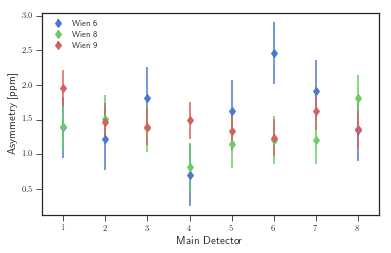

In [14]:
pp.figure(figsize=figsize(1.0))
pp.errorbar(data.det, data.w6_asym, yerr = data.w6_err, ls='None', marker='d', label='Wien 6')
pp.errorbar(data.det, data.w8_asym, yerr = data.w8_err, ls='None', marker='d', label='Wien 8')
pp.errorbar(data.det, data.w9_asym, yerr = data.w9_err, ls='None', marker='d', label='Wien 9')
pp.xlim(0.5,8.5)
pp.legend(loc='upper left')
pp.tick_params(top='off')
pp.xlabel('Main Detector')
pp.ylabel('Asymmetry [ppm]')
pp.show()

In [13]:
fit_x = np.linspace(0.5,8.5,100)
# Perform fit
w6_popt, w6_pcov = curve_fit(fit_function, data.det, data.w6_asym, sigma=data.w6_err)
w6_perr = np.sqrt(np.diag(w6_pcov))

w8_popt, w8_pcov = curve_fit(fit_function, data.det, data.w8_asym, sigma=data.w8_err)
w8_perr = np.sqrt(np.diag(w8_pcov))

w9_popt, w9_pcov = curve_fit(fit_function, data.det, data.w9_asym, sigma=data.w9_err)
w9_perr = np.sqrt(np.diag(w9_pcov))

In [14]:
# Old Calculation Chi^2 and probability of fit versus data
#w6_rchi2, w6_prob = chisquare(data.w6_asym, fit_function(data.det, *w6_popt))
#w8_rchi2, w8_prob = chisquare(data.w8_asym, fit_function(data.det, *w8_popt))
#w9_rchi2, w9_prob = chisquare(data.w9_asym, fit_function(data.det, *w9_popt))

w6_chi2, w6_rchi2 = calc_chi2(fit_function(data.det, *w6_popt), data.w6_asym, data.w6_err, 3)
w6_prob = calc_chi2prob(w6_chi2, 3)

w8_chi2, w8_rchi2 = calc_chi2(fit_function(data.det, *w8_popt), data.w8_asym, data.w8_err, 3)
w8_prob = calc_chi2prob(w8_chi2, 3)

w9_chi2, w9_rchi2 = calc_chi2(fit_function(data.det, *w9_popt), data.w9_asym, data.w9_err, 3)
w9_prob = calc_chi2prob(w9_chi2, 3)

In [15]:
np.round([(w6_rchi2, w6_prob[0]), (w8_rchi2, w8_prob[0]), (w9_rchi2, w9_prob[0])], 3)

array([[2.051, 0.104],
       [0.622, 0.601],
       [1.272, 0.282]])

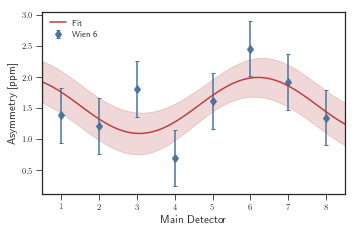

In [16]:
pp.figure(figsize=figsize(0.9))
pp.errorbar(data.det, 
            data.w6_asym, 
            yerr = data.w6_err, 
            ls='None', 
            marker='d', 
            label='Wien 6',
            capsize=2,
            capthick=1,
            barsabove=True,
            color=sns.xkcd_rgb['dull blue'])
pp.plot(fit_x,
        fit_function(fit_x, *w6_popt), 
        ls= '-', 
        label='Fit', 
        color=sns.xkcd_rgb['dull red'])
pp.fill_between(fit_x, 
                fit_function(fit_x, *w6_popt) + fit_func_err(fit_x, w6_pcov, *w6_popt), 
                fit_function(fit_x, *w6_popt) - fit_func_err(fit_x, w6_pcov, *w6_popt), 
                color=sns.xkcd_rgb['dull red'], alpha=0.2)
pp.xlim(0.5,8.5)
pp.legend(loc='upper left')
pp.xlabel('Main Detector')
pp.ylabel('Asymmetry [ppm]')
pp.savefig('plots/al_trans_leakage_wien6_md_phys_asym.png', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien6_md_phys_asym.pdf', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien6_md_phys_asym.pgf', bbox_inches='tight')
pp.show()

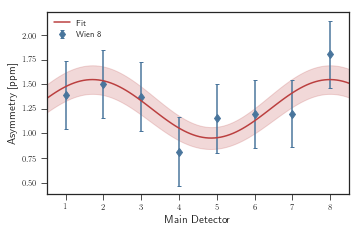

In [17]:
pp.figure(figsize=figsize(0.9))
pp.errorbar(data.det, 
            data.w8_asym, 
            yerr = data.w8_err, 
            ls='None', 
            marker='d', 
            label='Wien 8',
            capsize=2,
            capthick=1,
            barsabove=True,
            color=sns.xkcd_rgb['dull blue'])
pp.plot(fit_x,
        fit_function(fit_x, *w8_popt), 
        ls='-',
        label='Fit',
        color=sns.xkcd_rgb['dull red'])
pp.fill_between(fit_x, 
                fit_function(fit_x, *w8_popt) + fit_func_err(fit_x, w8_pcov, *w8_popt), 
                fit_function(fit_x, *w8_popt) - fit_func_err(fit_x, w8_pcov, *w8_popt),
                color=sns.xkcd_rgb['dull red'], alpha=0.2)
pp.xlim(0.5,8.5)
pp.legend(loc='upper left')
pp.xlabel('Main Detector')
pp.ylabel('Asymmetry [ppm]')
pp.savefig('plots/al_trans_leakage_wien8_md_phys_asym.png', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien8_md_phys_asym.pdf', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien8_md_phys_asym.pgf', bbox_inches='tight')
pp.show()

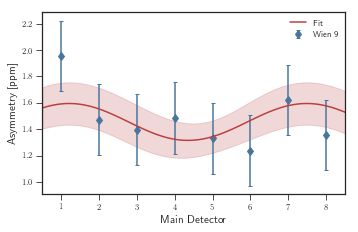

In [18]:
pp.figure(figsize=figsize(0.9))
pp.errorbar(data.det,
            data.w9_asym,
            yerr = data.w9_err,
            ls='None', marker='d',
            label='Wien 9',
            capsize=2,
            capthick=1,
            barsabove=True,
            color=sns.xkcd_rgb['dull blue'])
pp.plot(fit_x,
        fit_function(fit_x, *w9_popt), 
        ls='-',
        label='Fit',
        color=sns.xkcd_rgb['dull red'])
pp.fill_between(fit_x, 
                fit_function(fit_x, *w9_popt) + fit_func_err(fit_x, w9_pcov, *w9_popt), 
                fit_function(fit_x, *w9_popt) - fit_func_err(fit_x, w9_pcov, *w9_popt),
                color=sns.xkcd_rgb['dull red'], alpha=0.2)
pp.xlim(0.5,8.5)
pp.legend(loc='upper right')
pp.xlabel('Main Detector')
pp.ylabel('Asymmetry [ppm]')
pp.savefig('plots/al_trans_leakage_wien9_md_phys_asym.png', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien9_md_phys_asym.pdf', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien9_md_phys_asym.pgf', bbox_inches='tight')
pp.show()

In [38]:
fit_params = np.array([w6_popt, w8_popt, w9_popt])
fit_params_err = np.array([w6_perr, w8_perr, w9_perr])

In [39]:
fit_params[:]

array([[-0.05252889, -0.00421551,  1.54285518],
       [ 0.0047871 ,  0.03453717,  1.24938076],
       [-0.00584664,  0.01530721,  1.45468772]])

In [40]:
fit_params_err

array([[0.03133518, 0.0282838 , 0.18203035],
       [0.01337653, 0.01207926, 0.07769173],
       [0.014814  , 0.01337745, 0.08604389]])

In [41]:
pv_param = fit_params.transpose()[0][:]
pv_param_err = fit_params_err.transpose()[0][:]
ph_param = fit_params.transpose()[1][:]
ph_param_err = fit_params_err.transpose()[1][:]

In [42]:
pv_avg, pv_sw = np.average(pv_param, weights=1/np.square(pv_param_err), returned=True)
pv_avg_err = 1/np.sqrt(pv_sw)

ph_avg, ph_sw = np.average(ph_param, weights=1/np.square(ph_param_err), returned=True)
ph_avg_err = 1/np.sqrt(ph_sw)

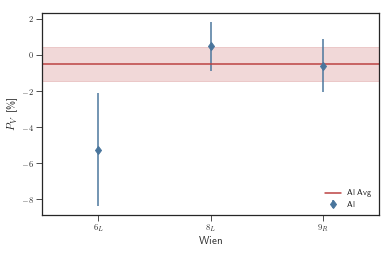

In [43]:
pp.figure(figsize=figsize(1.0))
pp.errorbar([1,2,3],
            pv_param*100.0,
            yerr=pv_param_err*100.0,
            ls='None', marker='d',
            color=sns.xkcd_rgb['dull blue'],
            label='Al')
pp.plot([0.5,3.5],
        [pv_avg*100.0, pv_avg*100.0],
        ls='-',
        label='Al Avg',
        color=sns.xkcd_rgb['dull red'])
pp.fill_between([0.5,3.5],
                (pv_avg+pv_avg_err)*100.0,
                (pv_avg-pv_avg_err)*100.0,
                color=sns.xkcd_rgb['dull red'], alpha=0.2)
pp.xlim(0.5,3.5)
pp.xticks([1,2,3],['$6_{L}$','$8_{L}$','$9_{R}$'])
pp.xlabel('Wien')
pp.ylabel('$P_{V}$ [\%]')
pp.legend(loc='lower right')
pp.savefig('plots/al_trans_leakage_wien_pv.png', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien_pv.pdf', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien_pv.pgf', bbox_inches='tight')
pp.show()

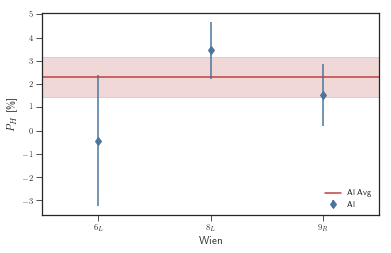

In [46]:
pp.figure(figsize=figsize(1.0))
pp.errorbar([1,2,3],
            ph_param*100.0,
            yerr=ph_param_err*100.0,
            ls='None',
            marker='d',
            color=sns.xkcd_rgb['dull blue'],
            label='Al')
pp.plot([0.5,3.5],
        [ph_avg*100.0, ph_avg*100.0],
        ls='-',
        label='Al Avg',
        color=sns.xkcd_rgb['dull red'])
pp.fill_between([0.5,3.5],
                (ph_avg+ph_avg_err)*100.0,
                (ph_avg-ph_avg_err)*100.0,
                color=sns.xkcd_rgb['dull red'], alpha=0.2)
pp.xlim(0.5,3.5)
pp.xticks([1,2,3],['$6_{L}$','$8_{L}$','$9_{R}$'])
pp.tick_params(top='off')
pp.xlabel('Wien')
pp.ylabel('$P_{H}$ [\%]')
pp.legend(loc='lower right')
pp.savefig('plots/al_trans_leakage_wien_ph.png', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien_ph.pdf', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien_ph.pgf', bbox_inches='tight')
pp.show()

In [32]:
# Hydrogen P_V and P_H for same wiens (6, 8, 8.5, 9, 9.5). See A&S ELOG 1663, in units of [%]
lh2_pv = [-0.3026, -1.3647, -1.6369, -1.5995, -0.4691]
lh2_pv_err = [0.6529,  0.5254, 0.5416, 0.4354, 0.4197]
lh2_ph = [-5.8870, 1.4373, 0.3290, 1.7305, -0.4754]
lh2_ph_err = [0.6523, 0.5260, 0.5422, 0.4363, 0.4197]

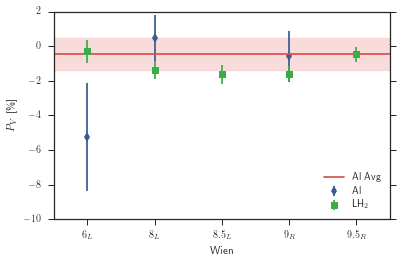

In [50]:
pp.figure(figsize=figsize(1.0))
pp.errorbar([1,2,4],pv_param*100.0, yerr=pv_param_err*100.0, ls='None', marker='d', color=sns.xkcd_rgb['denim blue'], label='Al')
pp.plot([0.5,5.5],[pv_avg*100.0, pv_avg*100.0], 'r-', label='Al Avg', color=sns.xkcd_rgb['pale red'])
pp.fill_between([0.5,5.5], (pv_avg+pv_avg_err)*100.0, (pv_avg-pv_avg_err)*100.0, color=sns.xkcd_rgb['pale red'], alpha=0.2)
pp.errorbar([1,2,3,4,5], lh2_pv, yerr=lh2_pv_err, ls='None', marker='s', color=sns.xkcd_rgb['medium green'], label='LH$_{2}$')
pp.xlim(0.5,5.5)
pp.xticks([1,2,3,4,5],['$6_{L}$','$8_{L}$','$8.5_{L}$','$9_{R}$','$9.5_{R}$'])
pp.tick_params(top='off')
pp.xlabel('Wien')
pp.ylabel('$P_{V}$ [\%]')
pp.legend(loc='lower right')
pp.savefig('plots/al_trans_leakage_wien_pv_lh2_compare.png', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien_pv_lh2_compare.pdf', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien_pv_lh2_compare.pgf', bbox_inches='tight')
pp.show()

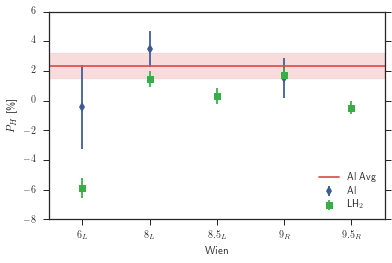

In [51]:
pp.figure(figsize=figsize(1.0))
pp.errorbar([1,2,4],ph_param*100.0, yerr=ph_param_err*100.0, ls='None', marker='d', color=sns.xkcd_rgb['denim blue'], label='Al')
pp.plot([0.5,5.5],[ph_avg*100.0, ph_avg*100.0], 'r-', label='Al Avg', color=sns.xkcd_rgb['pale red'])
pp.fill_between([0.5,5.5], (ph_avg+ph_avg_err)*100.0, (ph_avg-ph_avg_err)*100.0, color=sns.xkcd_rgb['pale red'], alpha=0.2)
pp.errorbar([1,2,3,4,5], lh2_ph, yerr=lh2_ph_err, ls='None', marker='s', color=sns.xkcd_rgb['medium green'], label='LH$_{2}$')
pp.xlim(0.5,5.5)
pp.xticks([1,2,3,4,5],['$6_{L}$','$8_{L}$','$8.5_{L}$','$9_{R}$','$9.5_{R}$'])
pp.tick_params(top='off')
pp.xlabel('Wien')
pp.ylabel('$P_{H}$ [\%]')
pp.legend(loc='lower right')
pp.savefig('plots/al_trans_leakage_wien_ph_lh2_compare.png', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien_ph_lh2_compare.pdf', bbox_inches='tight')
pp.savefig('plots/al_trans_leakage_wien_ph_lh2_compare.pgf', bbox_inches='tight')
pp.show()

In [50]:
np.round([pv_avg, pv_avg_err], 4)

array([-0.0048,  0.0095])

In [49]:
np.round([ph_avg, ph_avg_err], 4)

array([0.0232, 0.0085])

In [29]:
c_l = c_v*pv_avg + c_h*ph_avg
c_l_err = np.sqrt(c_v_err*c_v_err*pv_avg*pv_avg + pv_avg_err*pv_avg_err*c_v*c_v + c_h_err*c_h_err*ph_avg*ph_avg + ph_avg_err*ph_avg_err*c_h*c_h)

In [30]:
c_l, c_l_err

(-0.003419204623988174, 0.0087944421090125711)

In [31]:
abs(c_l-c_l_err) #dA_trans [ppm]

0.012213646733000745

In [52]:
abs(c_l)+abs(c_l_err)

0.012213646733000745